In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
import warnings
warnings.filterwarnings('ignore')
import astropy.coordinates as coord
import astropy.units as u
import corner

In [2]:
with open('../processed_data/Baseline_v_3_0/Baselinev30_unlensed_gband_batch001.pkl', 'rb') as f:
    sne = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_unlensed_batch001.pkl', 'rb') as f:
    sne_old = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_NEW_large_numimages=2_batch001.pkl', 'rb') as f:
    doubles = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_NEW_large_numimages=4_batch001.pkl', 'rb') as f:
    quads = pickle.load(f)

In [3]:
zd = doubles['z_source']
zq = quads['z_source']
zn = sne['z_source']

print("Fraction with redshift <= 0.8")
print(len(zd[zd <= 0.8])/len(zd))
print(len(zq[zq <= 0.8])/len(zq))
print(len(zn[zn <= 0.8])/len(zn))

Fraction with redshift <= 0.8
0.4042
0.3922
0.674


## Redshift distributions

In [5]:
def pdf_red(zmax):
    z = np.linspace(0, zmax, 100)
    rate = 2.35 * 10**4  # from Perley 2020
    volume = Planck18.comoving_volume(z).to("Gpc**3").value
    z_rate = volume * rate
    rates = np.diff(z_rate)
    pdf = rates/np.nansum(rates)
    x = (z[:-1]+z[1:])*.5
    return x, pdf

z, rate = pdf_red(zmax=1.2)

print(len(sne))

5000


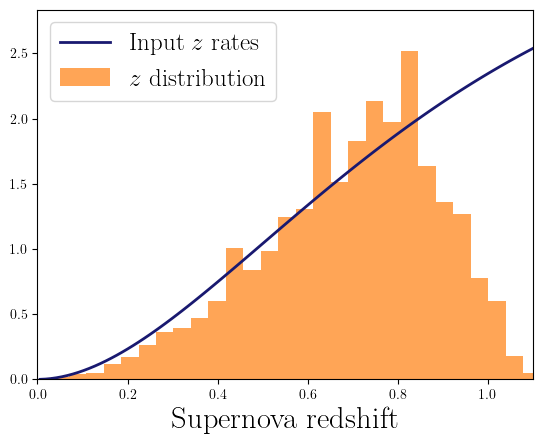

In [9]:
plt.hist(sne['z_source'], bins=30, color='C1', alpha=0.7, density=True, label=r'$z$ distribution')
plt.plot(z, rate * 130, color='midnightblue', lw=2, label=r'Input $z$ rates')
plt.legend(fontsize=18)
plt.xlim(0, 1.1)
plt.xlabel(r"Supernova redshift", fontsize=22)
plt.show()

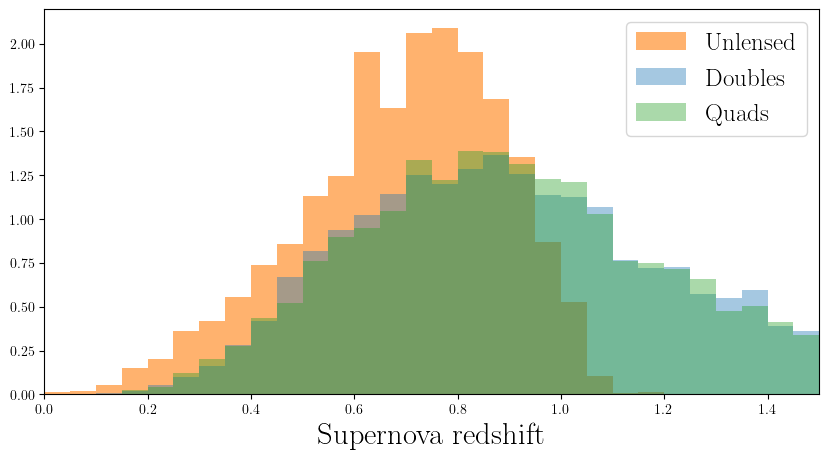

In [61]:
plt.figure(figsize=(10, 5))
zrange = (0, 1.5)
plt.hist(sne['z_source'], bins=30, color='C1', alpha=0.6, density=True, label=r'Unlensed', range=zrange)
# plt.hist(sne_old['z_source'], bins=30, color='C1', histtype='step', density=True, range=zrange, lw=2)
plt.hist(doubles['z_source'], bins=30, color='C0', alpha=0.4, density=True, label=r'Doubles', range=zrange)
plt.hist(quads['z_source'], bins=30, color='C2', alpha=0.4, density=True, label=r'Quads', range=zrange)
plt.legend(fontsize=18)
plt.xlim(0, 1.5)
plt.xlabel(r"Supernova redshift", fontsize=22)
plt.savefig("../Results/Figures/Results_0506/z_distributions_lensed_unlensed.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

## Yearly rates and number of observations

In [6]:
mlim = 25
filters = ['g', 'r', 'i', 'z', 'y']
dt_doubles, dt_quads = [], []
Nobs_doubles, Nobs_quads = [], []
duration_doubles, duration_quads = [], []
mutot_doubles, mutot_quads = [], []
m_peak_doubles, m_peak_quads = [], []
md_3det2band, mq_3det2band = [], []
md_5det2band, mq_5det2band = [], []

for s in range(len(doubles)):
    
    dt_doubles.append(doubles['time_delay'][s][1])
    dt_quads.append(max(quads['time_delay'][s]))
    
    #if len(doubles[])
    
    try:
        Nobs_doubles.append(len(doubles['snr_unresolved'][s][doubles['snr_unresolved'][s] > 5]))
        Nobs_quads.append(len(quads['snr_unresolved'][s][quads['snr_unresolved'][s] > 5]))
    except:
        print("nan added to Nobs")
        Nobs_doubles.append(np.nan)
        Nobs_quads.append(np.nan)
        
    duration_doubles.append(doubles['obs_end'][s] - doubles['obs_start'][s])
    duration_quads.append(quads['obs_end'][s] - quads['obs_start'][s])
    mutot_doubles.append(np.sum(doubles['macro_mag'][s]))
    mutot_quads.append(np.sum(quads['macro_mag'][s]))
    m_peak_doubles.append(np.nanmin(doubles['obs_mag_unresolved'][s]))
    m_peak_quads.append(np.nanmin(quads['obs_mag_unresolved'][s]))
    
    # Check detection criteria
    if len(doubles['snr_unresolved'][s][doubles['snr_unresolved'][s] > 5]) >= 3:
        filters5sig = doubles['obs_bands'][s][doubles['snr_unresolved'][s] > 5]
        if len(np.intersect1d(filters, filters5sig)) >= 2:
            md_3det2band.append(True)
        else:
            md_3det2band.append(False)
    else:
        md_3det2band.append(False)
        
    if len(quads['snr_unresolved'][s][quads['snr_unresolved'][s] > 5]) >= 3:
        filters5sig = quads['obs_bands'][s][quads['snr_unresolved'][s] > 5]
        if len(np.intersect1d(filters, filters5sig)) >= 2:
            mq_3det2band.append(True)
        else:
            mq_3det2band.append(False)
    else:
        mq_3det2band.append(False)
        
    # Check detection criteria
    if len(doubles['snr_unresolved'][s][doubles['snr_unresolved'][s] > 5]) >= 5:
        filters5sig = doubles['obs_bands'][s][doubles['snr_unresolved'][s] > 5]
        if len(np.intersect1d(filters, filters5sig)) >= 2:
            md_5det2band.append(True)
        else:
            md_5det2band.append(False)
    else:
        md_5det2band.append(False)
        
    if len(quads['snr_unresolved'][s][quads['snr_unresolved'][s] > 5]) >= 5:
        filters5sig = quads['obs_bands'][s][quads['snr_unresolved'][s] > 5]
        if len(np.intersect1d(filters, filters5sig)) >= 2:
            mq_5det2band.append(True)
        else:
            mq_5det2band.append(False)
    else:
        mq_5det2band.append(False)
    
    
dt_doubles = np.array(dt_doubles)
dt_quads = np.array(dt_quads)
Nobs_doubles = np.array(Nobs_doubles)
Nobs_quads = np.array(Nobs_quads)
duration_doubles = np.array(duration_doubles)
duration_quads = np.array(duration_quads)
mutot_doubles = np.array(mutot_doubles)
mutot_quads = np.array(mutot_quads)
m_peak_doubles = np.array(m_peak_doubles)
m_peak_quads = np.array(m_peak_quads)
md_3det2band = np.array(md_3det2band)
mq_3det2band = np.array(mq_3det2band)
md_5det2band = np.array(md_5det2band)
mq_5det2band = np.array(mq_5det2band)

In [8]:
# masks

# Rolling / non-rolling
md_nonrol = (doubles['obs_start']) <= 60768
md_rol = (doubles['obs_start']) > 60768
mq_nonrol = (quads['obs_start']) <= 60768
mq_rol = (quads['obs_start']) > 60768

# Survey
md_WFD = (doubles['survey']) == 'WFD'
md_DDF = (doubles['survey']) == 'DDF'
md_gal = (doubles['survey']) == 'galactic plane'
mq_WFD = (quads['survey']) == 'WFD'
mq_DDF = (quads['survey']) == 'DDF'
mq_gal = (quads['survey']) == 'galactic plane'

# Detected
md_detected = (doubles['mag_method'] == True) | (doubles['mult_method'] == True)
md_detected_micro = (doubles['mag_method_micro'] == True) | (doubles['mult_method_micro'] == True)
md_detected_peak = (doubles['mag_method_peak'] == True) | (doubles['mult_method_peak'] == True)
md_nondetect_micro = (doubles['mag_method_micro'] == False) & (doubles['mult_method_micro'] == False)
md_nondetect = (doubles['mag_method'] == False) & (doubles['mult_method'] == False)
mq_detected_micro = (quads['mag_method_micro'] == True) | (quads['mult_method_micro'] == True)
mq_detected = (quads['mag_method'] == True) | (quads['mult_method'] == True)
mq_nondetect_micro = (quads['mag_method_micro'] == False) & (quads['mult_method_micro'] == False)
mq_nondetect = (quads['mag_method'] == False) & (quads['mult_method'] == False)
mq_detected_peak = (quads['mag_method_peak'] == True) | (quads['mult_method_peak'] == True)

# Minimum number of observations
md_Nobs8 = Nobs_doubles > 8
md_Nobs30 = Nobs_doubles > 50
mq_Nobs8 = Nobs_quads > 8
mq_Nobs30 = Nobs_quads > 50
md_Nobs_lower15 = Nobs_doubles < 15
mq_Nobs_lower15 = Nobs_quads < 15
md_Nobs_zero = Nobs_doubles == 0
mq_Nobs_zero = Nobs_quads == 0

# Minimum time delay
dt_lim = 10
md_dt_lim = dt_doubles > dt_lim
mq_dt_lim = dt_quads > dt_lim

# Duration
md_duration = duration_doubles > 50
mq_duration = duration_quads > 50

In [9]:
indexx = 9
#print(doubles['snr_unresolved'][indexx])
#print(doubles['obs_bands'][indexx])
#print(" ")
filters5sig = doubles['obs_bands'][indexx][doubles['snr_unresolved'][indexx] > 5]
filters = ['g', 'r', 'i', 'z', 'y']
#print(filters5sig)
#print(np.intersect1d(filters, filters5sig))
#print(len(np.intersect1d(filters, filters5sig)))
#print(md_3det2band[:10])
#print(len(md_3det2band))

print(" ")

#print(md_detected_peak.sum(), mq_detected_peak.sum())
#print(md_detected.sum(), mq_detected.sum())
#print(md_detected_micro.sum(), mq_detected_micro.sum())

print(" ")
print("Fraction detected from total (numbers for in paper):")
print("Doubles: ", md_detected_micro.sum()/md_detected_peak.sum() * 100)
print("Quads: ", mq_detected_micro.sum()/mq_detected_peak.sum() * 100)

print(" ")
print(mq_Nobs_zero.sum())
print(Nobs_doubles)

print(doubles['obs_times'])

 
 
Fraction detected from total (numbers for in paper):
Doubles:  46.100403406544146
Quads:  69.58793969849246
 
768
[ 0  7  4 ...  0 20  6]
0       [-49.51931919069708, -41.69859758859093, -41.6...
1       [-39.311739135075186, -35.336397867235064, -31...
2       [-39.009861953956715, -35.09008456234733, -35....
3       [-29.682324220688315, -15.289276248935494, -15...
4       [-49.08927977064013, -41.15698605647776, -41.1...
                              ...                        
4995    [-31.148165132297436, -31.124057323861052, -26...
4996    [-32.97754179454205, -32.95370822523546, -30.7...
4997    [-44.61490764249902, -41.594882024910476, -32....
4998    [-38.216264635724656, -38.19180903295637, -3.3...
4999    [-33.21826083904792, -33.22634349470172, -32.2...
Name: obs_times, Length: 5000, dtype: object


In [285]:
print(md_detected_peak.sum(), mq_detected_peak.sum())
print(md_detected.sum(), mq_detected.sum())
print(md_detected_micro.sum(), mq_detected_micro.sum())

print(md_detected.sum()/md_detected_peak.sum() * 90)

781 951
272 330
124 221
31.344430217669654


In [231]:
signal = 22
lim_mag = 23
zp = 27.79

signal_flux = 10**((zp - signal)/2.5)
lim_flux = 10**((zp - lim_mag)/2.5)
flux_error = lim_flux / 5

snr = signal_flux / flux_error

print(snr)

12.559432157547905


In [10]:
# Yearly predicted rates by Wojtak et al.

rates_total = 89 * 3
fraction_quads = 0.28
fraction_doubles = 0.72
rates_quads = rates_total * fraction_quads
rates_doubles = rates_total * fraction_doubles

sd = rates_doubles / md_detected_peak.sum() / 1.5
sq = rates_quads / mq_detected_peak.sum() / 1.5

In [11]:
theta_min = 0.1
zsrc_max = 1.5

zlens_zSN_theta = np.load("../data/sample_zl_zsn_theta.npz")['zlens_zSN_theta']
zlens_zSN_theta = np.repeat(zlens_zSN_theta, 3, axis=0)

z_source_list_ = []
z_lens_list_ = []
theta_E_list_ = []

for m in range(zlens_zSN_theta.shape[0]):
    if zlens_zSN_theta[m, 1] < zsrc_max and zlens_zSN_theta[m, 1] > zlens_zSN_theta[m, 0] and \
            zlens_zSN_theta[m, 2] > theta_min:
        z_source_list_.append(zlens_zSN_theta[m, 1])
        z_lens_list_.append(zlens_zSN_theta[m, 0])
        theta_E_list_.append(zlens_zSN_theta[m, 2])
        
thetaE_input = np.array(theta_E_list_)

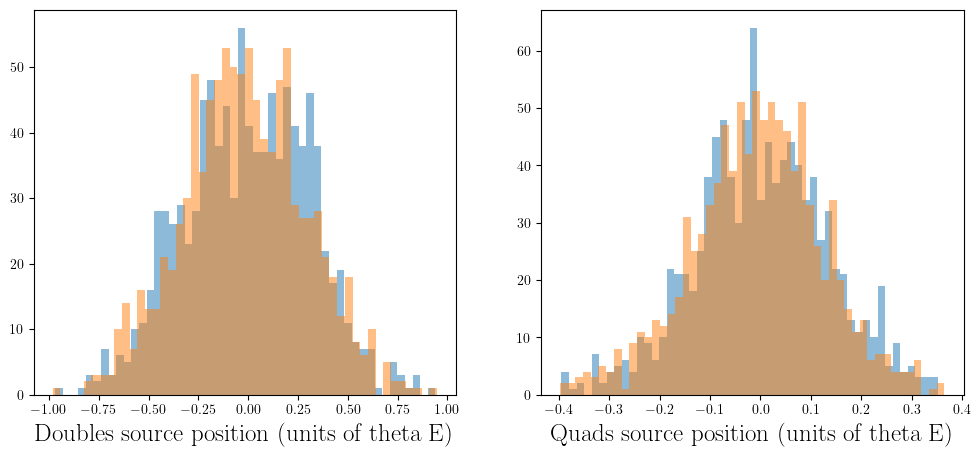

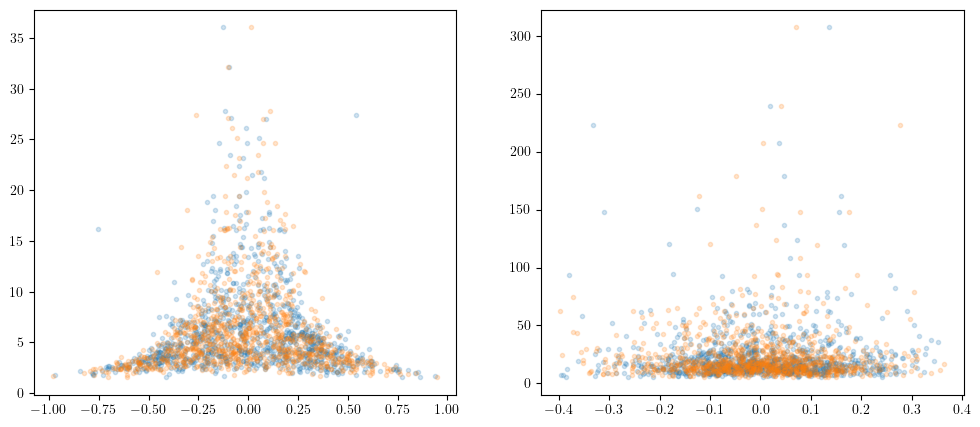

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(doubles['source_x'] / doubles['theta_E'], bins=50, alpha=0.5)
ax[0].hist(doubles['source_y'] / doubles['theta_E'], bins=50, alpha=0.5)
ax[0].set_xlabel("Doubles source position (units of theta E)", fontsize=18)

ax[1].hist(quads['source_x'] / quads['theta_E'], bins=50, alpha=0.5)
ax[1].hist(quads['source_y'] / quads['theta_E'], bins=50, alpha=0.5)
ax[1].set_xlabel("Quads source position (units of theta E)", fontsize=18)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(doubles['source_x'] / doubles['theta_E'], mutot_doubles, '.', alpha=0.2)
ax[0].plot(doubles['source_y'] / doubles['theta_E'], mutot_doubles, '.', alpha=0.2)

ax[1].plot(quads['source_x'] / quads['theta_E'], mutot_quads, '.', alpha=0.2)
ax[1].plot(quads['source_y'] / quads['theta_E'], mutot_quads, '.', alpha=0.2)

plt.show()

Text(0, 0.5, 'theta E')

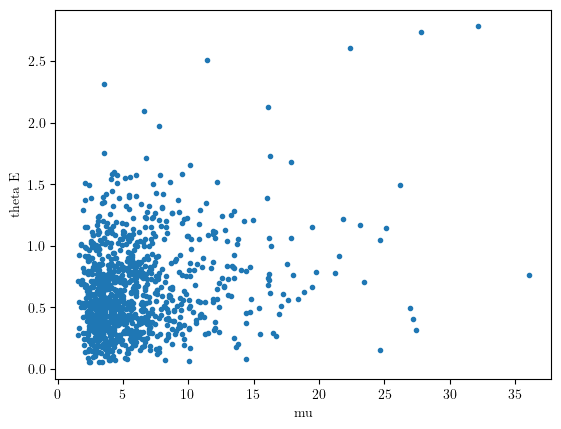

In [11]:
plt.plot(mutot_doubles, doubles['theta_E'], '.')
plt.xlabel("mu")
plt.ylabel("theta E")

In [169]:
print(quads['obs_snr'][0])
print(np.max(quads['obs_snr'][0], 0))
detections = np.max(quads['obs_snr'][0], 0)

print((detections > 5).sum())

[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.37668245 21.92892338 13.09082498  6.40960323]
 [ 2.5750903   6.30793459  3.89253983  2.17777799]
 [ 1.28980185  4.05854706  2.37416919  1.13783552]
 [ 9.61882057 17.65658087 11.92238979  7.51994256]
 [ 2.58904666  5.32078517  3.23803366  1.68513574]
 [ 5.84748438 10.33753145  7.39240016  5.23334522]
 [ 4.23899657  8.7366793   5.96543657  3.97431094]]
[10.37668245 21.92892338 13.09082498  7.51994256]
4


In [13]:
danny = pd.read_csv("../data/DannyGoldstein_sample.csv")
danny

,sysno,imno,td_max,mu_total,angsep_max,td_med,angsep_med,angsep_min,weights
0,16408,1,1.457672,3.715868,0.911548,0.728836,0.911548,0.911548,7.990033e-07
1,50827,3,4.098909,15.841425,1.149562,1.083166,0.934031,0.352762,1.051587e-04
2,59150,1,24.522026,26.290409,3.102395,12.261013,3.102395,3.102395,4.075984e-04
3,13501,3,7.003992,45.293393,0.810706,0.576201,0.687067,0.172752,1.403117e-03
4,53937,1,2.716084,2.654341,0.831518,1.358042,0.831518,0.831518,1.785754e-05
...,...,...,...,...,...,...,...,...,...
204767,9782142,1,0.357561,8.508919,0.234315,0.178780,0.234315,0.234315,5.745565e-05
204768,9950125,1,6.503927,4.610514,0.869820,3.251964,0.869820,0.869820,1.640979e-04
204769,9990761,1,38.483321,4.597233,1.196869,19.241660,1.196869,1.196869,3.373458e-03
204770,9752711,3,4.093343,12.734827,1.796393,0.336482,1.691402,0.719783,1.453801e-05


(array([3.46484532e+01, 5.14018772e-01, 0.00000000e+00, 1.26191668e+01,
        0.00000000e+00, 3.33379202e-02, 1.97343625e-02, 0.00000000e+00,
        2.59099850e-03, 1.18735075e-04]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

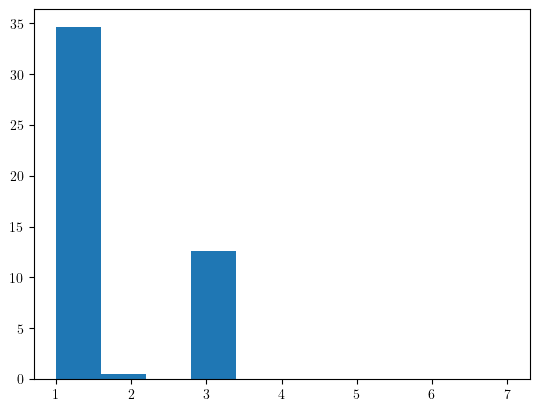

In [14]:
plt.hist(danny['imno'], weights=danny['weights'])

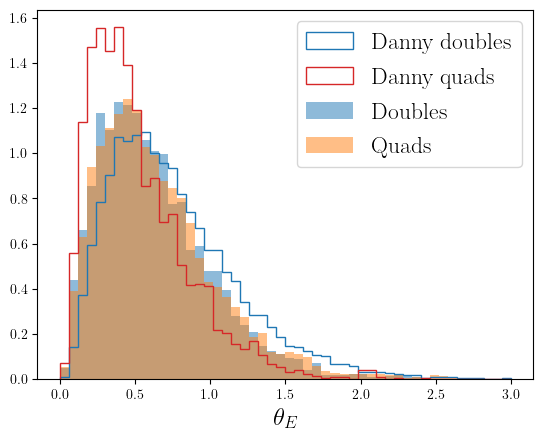

In [54]:

plt.hist(danny['angsep_med'][danny['imno'] == 1]/2, bins=50, histtype='step', density=True, range=(0,3), 
         weights=danny['weights'][danny['imno'] == 1], color='C0', label='Danny doubles')
plt.hist(danny['angsep_med'][danny['imno'] == 3]/2, bins=50, histtype='step', density=True, range=(0,3), 
         weights=danny['weights'][danny['imno'] == 3], color='C3', label='Danny quads')

plt.hist(doubles['theta_E'], bins=50, alpha=0.5, range=(0,3), density=True, label='Doubles')
plt.hist(quads['theta_E'], bins=50, alpha=0.5, range=(0,3), density=True, label='Quads')
plt.xlabel(r"$\theta_E$", fontsize=18)
plt.legend(fontsize=17)
#plt.savefig("../Results/Figures/DannyCheck_thetaE.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

# Compare really to image separation?

204772


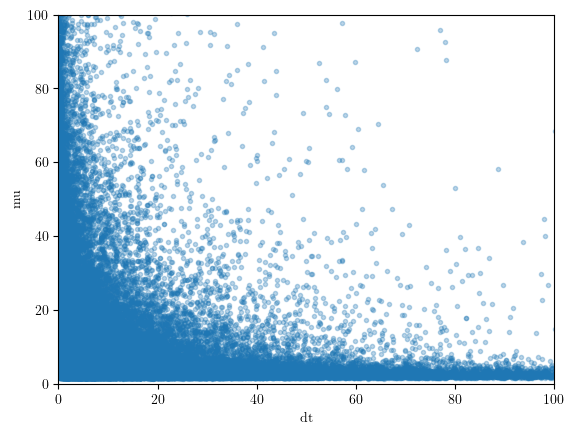

In [185]:
plt.plot(danny['td_max'], danny['mu_total'], '.', alpha=0.3)
plt.xlim(0, 100)
plt.ylim(0,100)
plt.xlabel('dt')
plt.ylabel('mu')


Text(0, 0.5, 'mu')

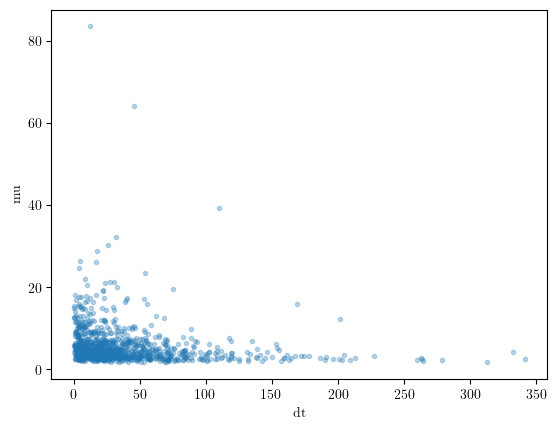

In [180]:
plt.plot(dt_doubles, mutot_doubles, '.', alpha=0.3)
plt.xlabel('dt')
plt.ylabel('mu')

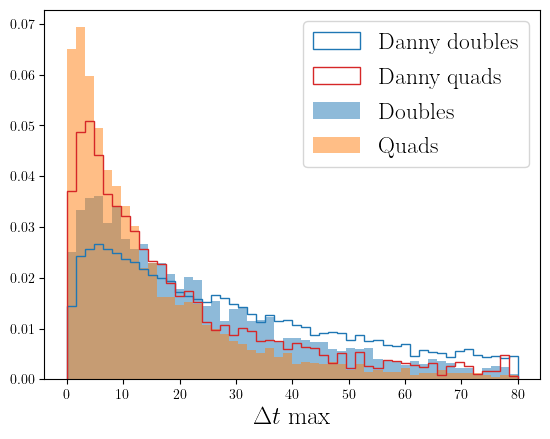

In [55]:

plt.hist(danny['td_max'][danny['imno'] == 1], bins=50, histtype='step', density=True, range=(0,80), 
         weights=danny['weights'][danny['imno'] == 1], color='C0', label='Danny doubles')
plt.hist(danny['td_max'][danny['imno'] == 3], bins=50, histtype='step', density=True, range=(0,80), 
         weights=danny['weights'][danny['imno'] == 3], color='C3', label='Danny quads')

plt.hist(dt_doubles, bins=50, alpha=0.5, range=(0,80), density=True, label='Doubles')
plt.hist(dt_quads, bins=50, alpha=0.5, range=(0,80), density=True, label='Quads')
plt.xlabel(r"$\Delta t$ max", fontsize=18)
plt.legend(fontsize=17)
#plt.savefig("../Results/Figures/DannyCheck_dt.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

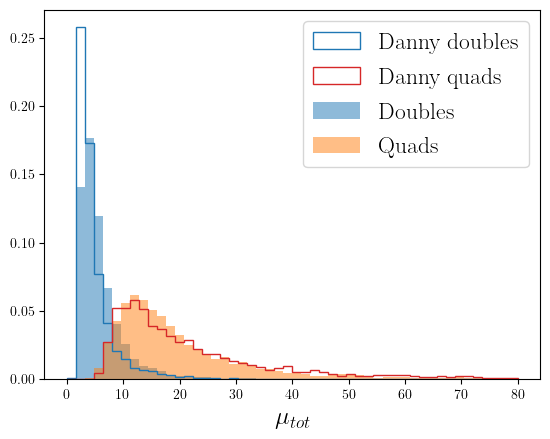

In [56]:
# print(quads['gamma_lens'])

plt.hist(danny['mu_total'][danny['imno'] == 1], bins=50, histtype='step', density=True, range=(0,80), 
         weights=danny['weights'][danny['imno'] == 1], color='C0', label='Danny doubles')
plt.hist(danny['mu_total'][danny['imno'] == 3], bins=50, histtype='step', density=True, range=(0,80), 
         weights=danny['weights'][danny['imno'] == 3], color='C3', label='Danny quads')

plt.hist(mutot_doubles, bins=50, alpha=0.5, range=(0,80), density=True, label='Doubles')
plt.hist(mutot_quads, bins=50, alpha=0.5, range=(0,80), density=True, label='Quads')
plt.xlabel(r"$\mu_{tot}$", fontsize=18)
plt.legend(fontsize=17)
#plt.savefig("../Results/Figures/DannyCheck_mu.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

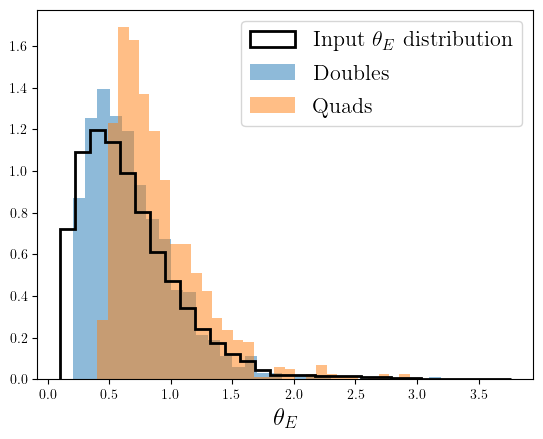

0.6943205303223307
0.8981238529329442


In [299]:
plt.hist(thetaE_input, bins=30, histtype='step', density=True, label=r'Input $\theta_E$ distribution', color='black', lw=2)
plt.hist((doubles['theta_E']), bins=30, alpha=0.5, density=True, label='Doubles', color='C0')
plt.hist((quads['theta_E']), bins=30, alpha=0.5, density=True, label='Quads', color='C1')
plt.legend(fontsize=16)
plt.xlabel(r"$\theta_E$", fontsize=18)
# plt.savefig("../Results/Figures/Einsteinradii_input_quadproblem.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

print(np.mean(doubles['theta_E']))
print(np.mean(quads['theta_E']))

--- Doubles ---
mu < 10
Number systems:  4320
Median time delay:  23.764639190236522
Danny unweighted median dt:  3.5659926582754777
Danny weighted median dt:  31.24728965300393
 
mu > 10
Number systems:  680
Median time delay:  12.798908827593673
Danny unweighted median dt:  1.5292319095791602
Danny weighted median dt:  15.290059731124614
 
--- Quads ---
mu < 10
Number systems:  801
Median time delay:  10.682954970542156
Danny unweighted median dt:  1.4486173564854075
Danny weighted median dt:  11.77454385036416
 
mu > 10
Number systems:  4199
Median time delay:  8.892518878611705
Danny unweighted median dt:  1.5243378484652808
Danny weighted median dt:  14.184411489036382
 
--- All ---
mu < 10
Danny unweighted median dt:  3.418332137052538
Danny weighted median dt:  29.858787516604824
 
mu > 10
Danny unweighted median dt:  1.4248422689856977
Danny weighted median dt:  14.055863453178215


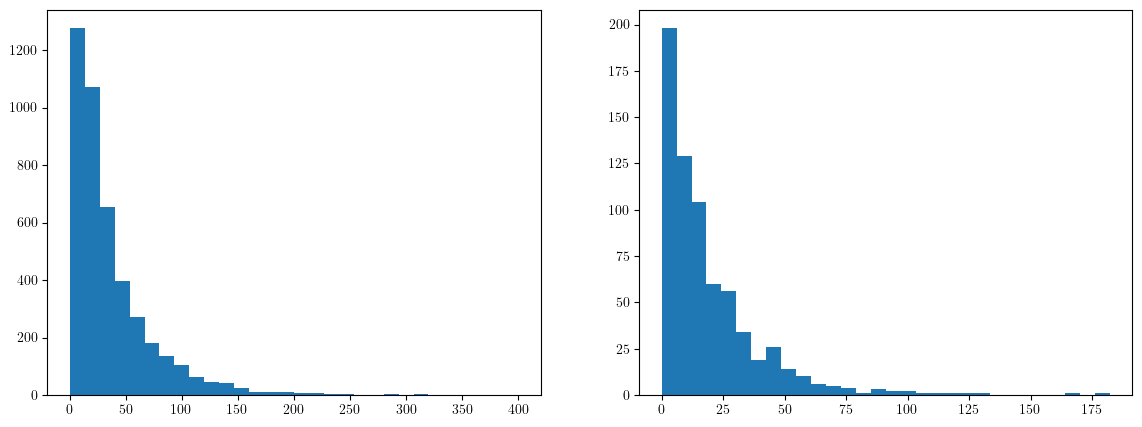

In [219]:
import weightedstats as ws

def weighted_median(values, weights):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]

danny_doubles_smallmu = (np.array(danny['mu_total']) < 10) & (np.array(danny['imno']) == 1)
danny_doubles_largemu = (np.array(danny['mu_total']) > 10) & (np.array(danny['imno']) == 1)
danny_quads_smallmu = (np.array(danny['mu_total']) < 10) & (np.array(danny['imno']) == 3)
danny_quads_largemu = (np.array(danny['mu_total']) > 10) & (np.array(danny['imno']) == 3)
danny_smallmu = (np.array(danny['mu_total']) < 10)
danny_largemu = (np.array(danny['mu_total']) > 10)

print("--- Doubles ---")
print("mu < 10")
print("Number systems: ", len(dt_doubles[mutot_doubles < 10]))
print("Median time delay: ", np.median(dt_doubles[mutot_doubles < 10]))
print("Danny unweighted median dt: ", np.median(np.array(danny['td_max'])[danny_doubles_smallmu]))
print("Danny weighted median dt: ", weighted_median(np.array(danny['td_max'])[danny_doubles_smallmu], 
                                                   np.array(danny['weights'])[danny_doubles_smallmu]))
print(" ")
print("mu > 10")
print("Number systems: ", len(dt_doubles[mutot_doubles > 10]))
print("Median time delay: ", np.median(dt_doubles[mutot_doubles > 10]))
print("Danny unweighted median dt: ", np.median(np.array(danny['td_max'])[danny_doubles_largemu]))
print("Danny weighted median dt: ", weighted_median(np.array(danny['td_max'])[danny_doubles_largemu], 
                                                   np.array(danny['weights'])[danny_doubles_largemu]))

print(" ")
print("--- Quads ---")
print("mu < 10")
print("Number systems: ", len(dt_quads[mutot_quads < 10]))
print("Median time delay: ", np.median(dt_quads[mutot_quads < 10]))
print("Danny unweighted median dt: ", np.median(np.array(danny['td_max'])[danny_quads_smallmu]))
print("Danny weighted median dt: ", weighted_median(np.array(danny['td_max'])[danny_quads_smallmu], 
                                                   np.array(danny['weights'])[danny_quads_smallmu]))
print(" ")
print("mu > 10")
print("Number systems: ", len(dt_quads[mutot_quads > 10]))
print("Median time delay: ", np.median(dt_quads[mutot_quads > 10]))
print("Danny unweighted median dt: ", np.median(np.array(danny['td_max'])[danny_quads_largemu]))
print("Danny weighted median dt: ", weighted_median(np.array(danny['td_max'])[danny_quads_largemu], 
                                                   np.array(danny['weights'])[danny_quads_largemu]))

print(" ")
print("--- All ---")
print("mu < 10")
print("Danny unweighted median dt: ", np.median(np.array(danny['td_max'])[danny_smallmu]))
#print("Danny weighted median dt: ", weighted_median(np.array(danny['td_max'])[danny_smallmu], 
#                                                   np.array(danny['weights'])[danny_smallmu]))
print("Danny weighted median dt: ", ws.weighted_median(np.array(danny['td_max'])[danny_smallmu], 
                                                       weights = np.array(danny['weights'])[danny_smallmu]))
print(" ")
print("mu > 10")
print("Danny unweighted median dt: ", np.median(np.array(danny['td_max'])[danny_largemu]))
#print("Danny weighted median dt: ", weighted_median(np.array(danny['td_max'])[danny_largemu], 
#                                                   np.array(danny['weights'])[danny_largemu]))
print("Danny weighted median dt: ", ws.weighted_median(np.array(danny['td_max'])[danny_largemu], 
                                                       weights = np.array(danny['weights'])[danny_largemu]))


fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].hist(dt_doubles[mutot_doubles < 10], bins=30)

ax[1].hist(dt_doubles[mutot_doubles > 10], bins=30)
plt.show()

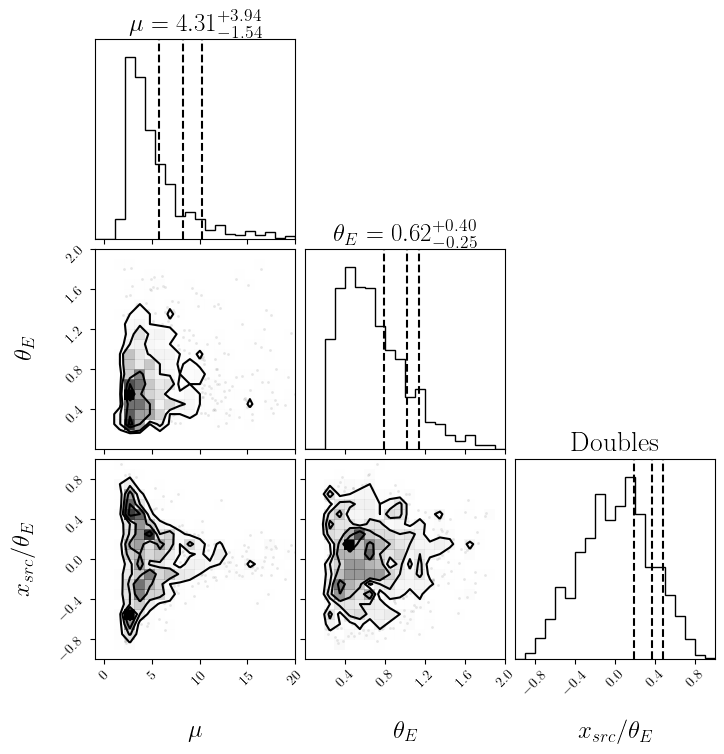

In [136]:
c_data = np.array([mutot_doubles, doubles['theta_E'], doubles['source_x']/doubles['theta_E']]).T
c_labels = [r"$\mu$", r"$\theta_E$", r"$x_{src} / \theta_E$"]
c_range = [[-1, 20], [0, 2], [-1, 1]]

corner.corner(c_data, labels=c_labels, quantiles=[0.68, 0.84, 0.9], range=c_range, show_titles=True,
             title_kwargs={"fontsize": 18}, label_kwargs={"fontsize": 18})
plt.title("Doubles", fontsize=20)
plt.show()

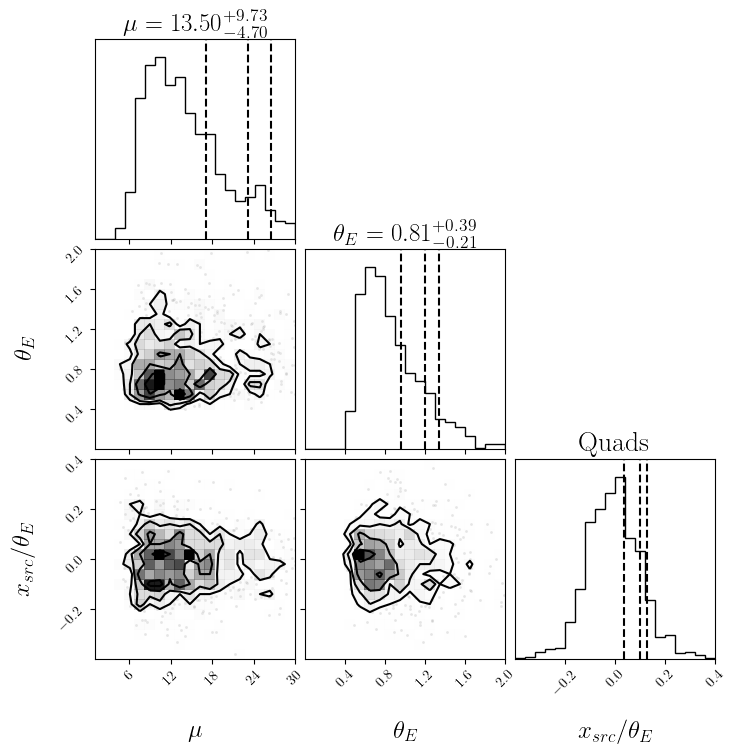

In [141]:
c_data = np.array([mutot_quads, quads['theta_E'], quads['source_x']/quads['theta_E']]).T
c_labels = [r"$\mu$", r"$\theta_E$", r"$x_{src} / \theta_E$"]
c_range = [[1, 30], [0, 2], [-0.4, 0.4]]

corner.corner(c_data, labels=c_labels, quantiles=[0.68, 0.84, 0.9], range=c_range, show_titles=True,
             title_kwargs={"fontsize": 18}, label_kwargs={"fontsize": 18})
plt.title("Quads", fontsize=20)
plt.show()

In [24]:
print("doubles mag method peak: ", doubles['mag_method_peak'].sum())
print("doubles mag method: ", doubles['mag_method'].sum())
print("doubles mag method micro: ", doubles['mag_method_micro'].sum())
print("doubles mult method peak: ", doubles['mult_method_peak'].sum())
print("doubles mult method: ", doubles['mult_method'].sum())
print("doubles mult method micro: ", doubles['mult_method_micro'].sum())
print(" ")
print("quads mag method peak: ", quads['mag_method_peak'].sum())
print("quads mag method: ", quads['mag_method'].sum())
print("quads mag method micro: ", quads['mag_method_micro'].sum())
print("quads mult method peak: ", quads['mult_method_peak'].sum())
print("quads mult method: ", quads['mult_method'].sum())
print("quads mult method micro: ", quads['mult_method_micro'].sum())

qindices1 = (quads['mag_method_peak'] == True) & (quads['mult_method_peak'] == False)
qindices2 = (quads['mag_method_peak'] == True) & (quads['mult_method_peak'] == True)

print(" ")
print((qindices1).sum())
print((qindices2).sum())
print((qindices1).sum() + (qindices2).sum())

doubles mag method peak:  611
doubles mag method:  143
doubles mag method micro:  166
doubles mult method peak:  525
doubles mult method:  396
doubles mult method micro:  295
 
quads mag method peak:  899
quads mag method:  576
quads mag method micro:  547
quads mult method peak:  632
quads mult method:  555
quads mult method micro:  476
 
359
540
899


(array([  0.,  34., 217., 236., 176., 115.,  65.,  61.,  24.,  25.,  13.,
         12.,   5.,   5.,   1.,   3.,   0.,   2.,   0.,   2.,   0.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.]),
 array([  0.        ,   3.33333333,   6.66666667,  10.        ,
         13.33333333,  16.66666667,  20.        ,  23.33333333,
         26.66666667,  30.        ,  33.33333333,  36.66666667,
         40.        ,  43.33333333,  46.66666667,  50.        ,
         53.33333333,  56.66666667,  60.        ,  63.33333333,
         66.66666667,  70.        ,  73.33333333,  76.66666667,
         80.        ,  83.33333333,  86.66666667,  90.        ,
         93.33333333,  96.66666667, 100.        ]),
 <BarContainer object of 30 artists>)

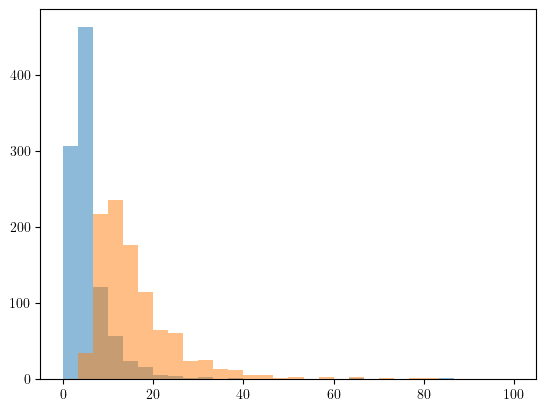

In [107]:
plt.hist((mutot_doubles), range=(0,100), bins=30, alpha=0.5)
plt.hist((mutot_quads), range=(0,100), bins=30, alpha=0.5)


(array([ 14.,  19.,  25.,  32.,  44.,  52.,  67.,  91., 106., 142., 123.,
        152., 151., 202., 164., 141., 123., 104.,  88.,  51.,  38.,  18.,
         15.,   7.,   6.,   2.,   0.,   0.,   0.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 30 artists>)

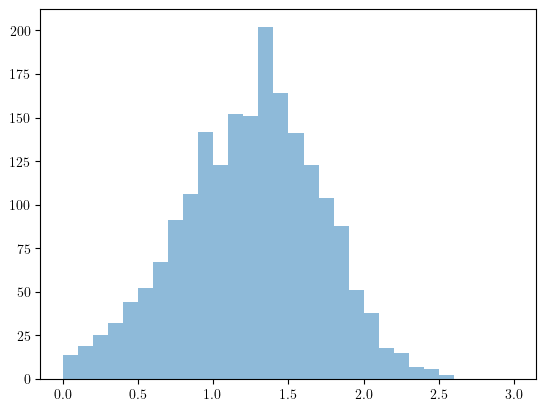

In [20]:
plt.hist(list(np.log10(dt_doubles)) + list(np.log10(dt_quads)), range=(0,3), bins=30, alpha=0.5)
#plt.hist(np.log10(dt_quads), range=(0,3), bins=30, alpha=0.5)

In [21]:
print(np.median(dt_quads))
print(np.median(dt_doubles))
print(np.median(list(dt_quads) + list(dt_doubles)))
print(10**1.39)
print(" ")
print((33.48536+29.38424)/2)

13.940934186513221
24.506173959295893
18.814401200201743
24.547089156850298
 
31.4348


In [46]:
x = ((md_WFD) & (mq_detected_peak) & (mq_rol)).sum()*sq + ((mq_WFD) & (md_detected_peak) & (md_rol)).sum()*sd
y = ((md_gal) & (mq_detected_peak) & (mq_rol)).sum()*sq + ((mq_gal) & (md_detected_peak) & (md_rol)).sum()*sd

print(x)
print(y)
print(x+y)

print(48+18)

print(66/89 * 100)

64.60396884530294
24.65997357754832
89.26394242285127
66
74.15730337078652


In [65]:
print("WFD")
print(" ")

print("--- Doubles ---")
print("             Non-rolling    ---    Rolling")
print("N detected peak:  ",  ((md_WFD) & (md_detected_peak) & (md_nonrol)).sum()*sd,"    ", 
                            ((md_WFD) & (md_detected_peak) & (md_rol)).sum()*sd)
print("N detected  :     ",  ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((md_WFD) & (md_detected) & (md_rol)).sum()*sd)
print("N detected micro: ",  ((md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd,"    ", 
                            ((md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd)
print(" ")

print("--- Quads ---")
print("             Non-rolling    ---    Rolling")
print("N detected peak:  ",  ((mq_WFD) & (mq_detected_peak) & (mq_nonrol)).sum()*sq,"    ", 
                            ((mq_WFD) & (mq_detected_peak) & (mq_rol)).sum()*sq)
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq)
print("N detected micro: ",  ((mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq)
print(" ")

print("--- Total ---")
print("             Non-rolling    ---    Rolling")
print("without microlensing:")
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq + ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq + ((md_WFD) & (md_detected) & (md_rol)).sum()*sd)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected) & (mq_nonrol) & (mq_dt_lim)).sum()*sq + ((md_WFD) & (md_detected) & (md_nonrol) & (md_dt_lim)).sum()*sd,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol) & (mq_dt_lim)).sum()*sq + ((md_WFD) & (md_detected) & (md_rol) & (md_dt_lim)).sum()*sd)
print("Total N of lensed SNe: ", (((md_WFD) & (md_detected)).sum()*sd + ((mq_WFD) & (mq_detected)).sum()*sq)/2)
print(" ")
print("with microlensing:")
print("N detected  :     ",  ((mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq + ((md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq + ((md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (mq_dt_lim)).sum()*sq + ((md_WFD) & (md_detected_micro) & (md_nonrol) & (md_dt_lim)).sum()*sd,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (mq_dt_lim)).sum()*sq + ((md_WFD) & (md_detected_micro) & (md_rol) & (md_dt_lim)).sum()*sd)
print("Total N of lensed SNe: ", (((md_WFD) & (md_detected_micro)).sum()*sd + ((mq_WFD) & (mq_detected_micro)).sum()*sq)/2)

WFD
 
--- Doubles ---
             Non-rolling    ---    Rolling
N detected peak:   48.85705064993276      48.13898700134468
N detected  :      29.842725235320483      26.051349170775435
N detected micro:  27.14280591662931      22.86314657104437
 
--- Quads ---
             Non-rolling    ---    Rolling
N detected peak:   18.523449246231156      18.593575879396987
N detected  :      15.09726231155779      14.275778894472362
N detected micro:  14.395995979899498      13.464313567839197
 
--- Total ---
             Non-rolling    ---    Rolling
without microlensing:
N detected  :      44.93998754687827      40.3271280652478
N with time delay > 10 days :  26.181315563924507      24.16071925742563
Total N of lensed SNe:  42.63355780606304
 
with microlensing:
N detected  :      41.53880189652881      36.327460138883566
N with time delay > 10 days :  24.79933419495505      21.941788879854222
Total N of lensed SNe:  38.93313101770619


In [16]:
print("WFD (based on simple scaling 20,000 >> 18,000)")
print(" ")

# Yearly predicted rates by Wojtak et al.

rates_total = 89 * 3
fraction_quads = 0.28
fraction_doubles = 0.72
rates_quads = rates_total * fraction_quads
rates_doubles = rates_total * fraction_doubles

sd2 = rates_doubles / ((md_WFD) & (md_detected_peak)).sum() / 1.5 /20000 * 18000
sq2 = rates_quads / ((mq_WFD) & (mq_detected_peak)).sum() / 1.5 /20000 * 18000

print("--- Doubles ---")
print("             Non-rolling    ---    Rolling")
print("N detected peak:  ",  ((md_WFD) & (md_detected_peak) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected_peak) & (md_rol)).sum()*sd2)
print("N detected  :     ",  ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected) & (md_rol)).sum()*sd2)
print("N detected micro: ",  ((md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("Micro & dt > 10 : ",  ((md_dt_lim) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_dt_lim) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("N 3 det. 2 bands: ",  ((md_3det2band) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_3det2band) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("N 5 det. 2 bands: ",  ((md_5det2band) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_5det2band) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)

print(" ")

print("--- Quads ---")
print("             Non-rolling    ---    Rolling")
print("N detected peak:  ",  ((mq_WFD) & (mq_detected_peak) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected_peak) & (mq_rol)).sum()*sq2)
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq2)
print("N detected micro: ",  ((mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("Micro & dt > 10  ",  ((mq_dt_lim) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_dt_lim) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("N 3 det. 2 bands: ",  ((mq_3det2band) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_3det2band) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("N 5 det. 2 bands: ",  ((mq_5det2band) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_5det2band) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print(" ")

print("--- Total ---")
print("             Non-rolling    ---    Rolling")
print("without microlensing:")
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_rol)).sum()*sd2)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected) & (mq_nonrol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_nonrol) & (md_dt_lim)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_rol) & (md_dt_lim)).sum()*sd2)
print("Total N of lensed SNe: ", (((md_WFD) & (md_detected)).sum()*sd2 + ((mq_WFD) & (mq_detected)).sum()*sq2)/2)
print(" ")

print("with microlensing:")
print("N detected  :     ",  ((mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol) & (md_dt_lim)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol) & (md_dt_lim)).sum()*sd2)
print("Total N of lensed SNe: ", (((md_WFD) & (md_detected_micro)).sum()*sd2 + ((mq_WFD) & (mq_detected_micro)).sum()*sq2)/2)

WFD (based on simple scaling 20,000 >> 18,000)
 
--- Doubles ---
             Non-rolling    ---    Rolling
N detected peak:   58.098946994373705      57.245053005626296
N detected  :      35.48783417234232      30.979273911755996
N detected micro:  32.27719277465206      27.187984601717503
Micro & dt > 10 :  21.723063073734085      18.444110156944035
N 3 det. 2 bands:  29.74966656795973      24.59214687592538
N 5 det. 2 bands:  27.93941131181522      22.20124370743263
 
--- Quads ---
             Non-rolling    ---    Rolling
N detected peak:   22.385625910931175      22.470374089068827
N detected  :      18.24507206477733      17.252307692307692
N detected micro:  17.39759028340081      16.27165020242915
Micro & dt > 10   7.893687449392713      7.772618623481782
N 3 det. 2 bands:  17.010170040485832      15.387847773279354
N 5 det. 2 bands:  16.1869020242915      14.152945748987856
 
--- Total ---
             Non-rolling    ---    Rolling
without microlensing:
N detected  :      53.

In [27]:
print("galactic plane")
print(" ")

print("--- Doubles ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((md_gal) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((md_gal) & (md_detected) & (md_rol)).sum()*sd)
print(" ")

print("--- Quads ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((mq_gal) & (mq_detected) & (mq_nonrol)).sum()*sq,"    ", 
                            ((mq_gal) & (mq_detected) & (mq_rol)).sum()*sq)
print(" ")

print("--- Total ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((mq_gal) & (mq_detected) & (mq_nonrol)).sum()*sq + ((md_gal) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((mq_gal) & (mq_detected) & (mq_rol)).sum()*sq + ((md_gal) & (md_detected) & (md_rol)).sum()*sd)
print("N with time delay > 10 days : ", ((mq_gal) & (mq_detected) & (mq_nonrol) & (mq_dt_lim)).sum()*sq + ((md_gal) & (md_detected) & (md_nonrol) & (md_dt_lim)).sum()*sd,"    ", 
                            ((mq_gal) & (mq_detected) & (mq_rol) & (mq_dt_lim)).sum()*sq + ((md_gal) & (md_detected) & (md_rol) & (md_dt_lim)).sum()*sd)
print("Total N of lensed SNe: ", (((md_gal) & (md_detected)).sum()*sd + ((mq_gal) & (mq_detected)).sum()*sq)/2)

galactic plane
 
--- Doubles ---
             Non-rolling    ---    Rolling
N detected  :      6.700244716351501      3.991635150166852
 
--- Quads ---
             Non-rolling    ---    Rolling
N detected  :      4.425751765893038      3.822240161453078
 
--- Total ---
             Non-rolling    ---    Rolling
N detected  :      11.125996482244538      7.813875311619929
N with time delay > 10 days :  5.416467899639581      4.611410144021443
Total N of lensed SNe:  9.469935896932235


In [66]:
print("DDF")
print(" ")

print("--- Doubles ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((md_DDF) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((md_DDF) & (md_detected) & (md_rol)).sum()*sd)
print(" ")

print("--- Quads ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((mq_DDF) & (mq_detected) & (mq_nonrol)).sum()*sq,"    ", 
                            ((mq_DDF) & (mq_detected) & (mq_rol)).sum()*sq)
print(" ")

print("--- Total ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((mq_DDF) & (mq_detected) & (mq_nonrol)).sum()*sq + ((md_DDF) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((mq_DDF) & (mq_detected) & (mq_rol)).sum()*sq + ((md_DDF) & (md_detected) & (md_rol)).sum()*sd)
print("N with time delay > 10 days : ", ((mq_DDF) & (mq_detected) & (mq_nonrol) & (mq_dt_lim)).sum()*sq + ((md_DDF) & (md_detected) & (md_nonrol) & (md_dt_lim)).sum()*sd,"    ", 
                            ((mq_DDF) & (mq_detected) & (mq_rol) & (mq_dt_lim)).sum()*sq + ((md_DDF) & (md_detected) & (md_rol) & (md_dt_lim)).sum()*sd)
print("Total N of lensed SNe: ", (((md_DDF) & (md_detected)).sum()*sd + ((mq_DDF) & (mq_detected)).sum()*sq)/2)

DDF
 
--- Doubles ---
             Non-rolling    ---    Rolling
N detected  :      0.11489018377409232      0.1436127297176154
 
--- Quads ---
             Non-rolling    ---    Rolling
N detected  :      0.04007236180904523      0.10018090452261307
 
--- Total ---
             Non-rolling    ---    Rolling
N detected  :      0.15496254558313755      0.24379363424022849
N with time delay > 10 days :  0.06746318233930747      0.1462761805441371
Total N of lensed SNe:  0.19937808991168302


In [30]:
print(len(doubles[(md_DDF) & (md_detected)]))
print(len(quads[(mq_DDF) & (mq_detected)]))

0
3


Time delay:  21.565710314293284
Detected?  False
Micro peak:  [ 0.286 -1.665]
 
Time delay:  53.80484791024018
Detected?  True
Micro peak:  [0.112 0.177]
 
Time delay:  45.7299233218357
Detected?  True
Micro peak:  [ 0.336 -0.416]
 


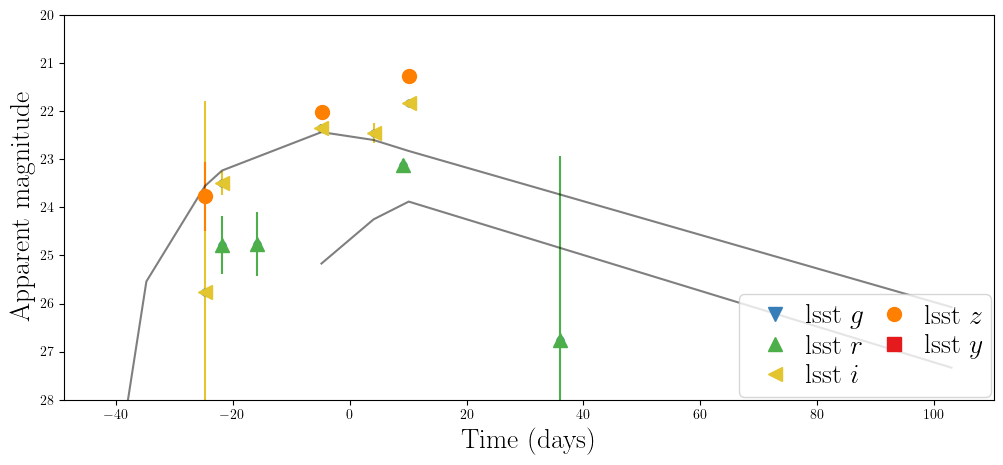

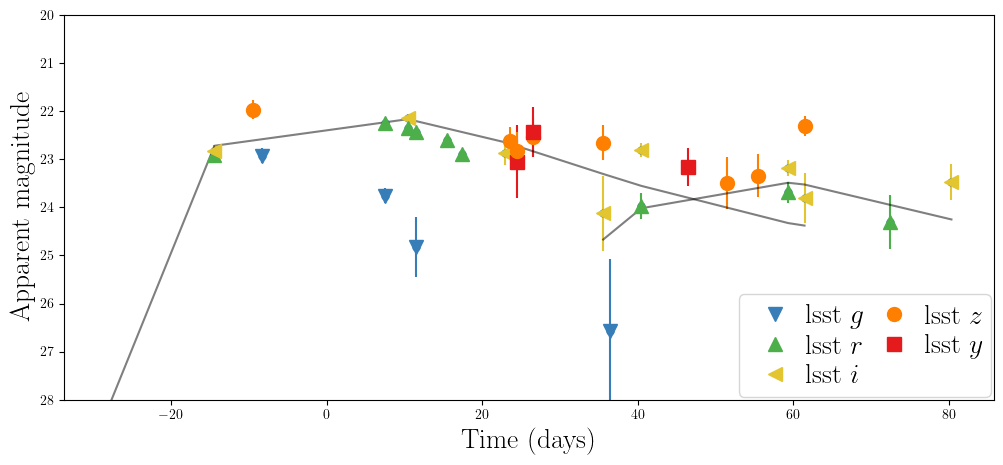

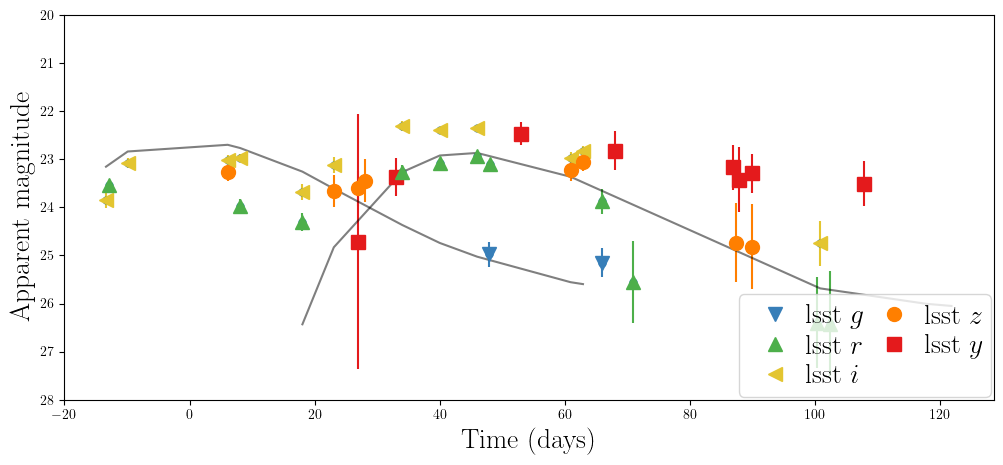

In [31]:
for index in np.where(mq_DDF)[0]:
    
    print("Time delay: ", doubles['time_delay'][index][1])
    print("Detected? ", md_detected[index])
    print("Micro peak: ", doubles['micro_peak'][index])
    print(" ")
    
    plt.figure(figsize=(12, 5))

    colours = {'lsstg': '#377eb8', 'lsstr': '#4daf4a',
                       'lssti': '#e3c530', 'lsstz': '#ff7f00', 'lssty': '#e41a1c'}

    markers = {'lsstg': 'v', 'lsstr': '^',
               'lssti': '<', 'lsstz': 'o', 'lssty': 's'}

    legend_handles = [Line2D([0], [0], marker=markers['lsstg'], color=colours['lsstg'], label=r'lsst $g$', ms=10, lw=0),
                          Line2D([0], [0], marker=markers['lsstr'], color=colours['lsstr'], label=r'lsst $r$', ms=10, lw=0),
                          Line2D([0], [0], marker=markers['lssti'], color=colours['lssti'], label=r'lsst $i$', ms=10, lw=0),
                          Line2D([0], [0], marker=markers['lsstz'], color=colours['lsstz'], label=r'lsst $z$', ms=10, lw=0),
                          Line2D([0], [0], marker=markers['lssty'], color=colours['lssty'], label=r'lsst $y$', ms=10, lw=0)]

    legend1 = plt.legend(handles=legend_handles, loc='lower right', ncol=2, handletextpad=.1, borderaxespad=.1,
                         labelspacing=.1, borderpad=.3, columnspacing=.1, fontsize=20)

    df = doubles
    day = df['obs_times'][index]
    mags = df['mag_unresolved_micro'][index]
    error = df['mag_unresolved_micro_error'][index]
    filters = df['obs_bands'][index]
    mag_im1 = df['model_mag'][index][:,0][filters == 'i']
    mag_im2 = df['model_mag'][index][:,1][filters == 'i']

    plt.plot(day, mags, '.' , ms=10)
    plt.plot(day[filters == 'i'], mag_im1, color='black', alpha=0.5)
    plt.plot(day[filters == 'i'], mag_im2, color='black', alpha=0.5)

    for obs in range(len(day)):
        band = 'lsst' + filters[obs]
        plt.plot(day[obs], mags[obs], color=colours[band], marker=markers[band], ms=10, label=band)
        plt.vlines(day[obs], mags[obs] - error[obs], mags[obs] + error[obs], color=colours[band])

    plt.xlabel("Time (days)", fontsize=20)
    plt.ylabel("Apparent magnitude", fontsize=20)
    plt.ylim(28, 20)

## Lensed SN sky location

In [32]:
d_ra, d_dec = [], []
q_ra, q_dec = [], []

for c in range(len(doubles)):
    d_ra.append(doubles['coords'][c][0])
    d_dec.append(doubles['coords'][c][1])
    q_ra.append(quads['coords'][c][0])
    q_dec.append(quads['coords'][c][1])

d_ra = coord.Angle(np.array(d_ra), u.degree)
d_dec = coord.Angle(np.array(d_dec), u.degree)
q_ra = coord.Angle(np.array(q_ra), u.degree)
q_dec = coord.Angle(np.array(q_dec), u.degree)
d_ra = - d_ra.wrap_at(180*u.degree)
q_ra = - q_ra.wrap_at(180*u.degree)

389
566
 
75
164


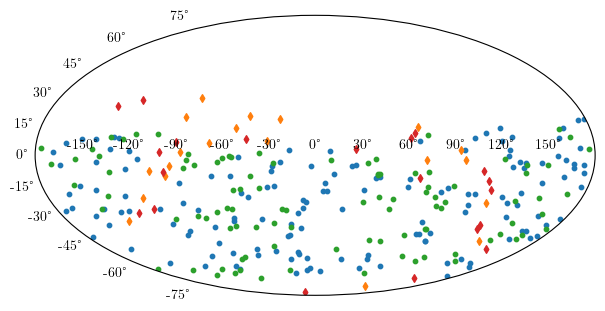

In [33]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, projection="mollweide")
im1 = ax1.scatter(d_ra.radian[(md_WFD) & (md_detected)][:150], d_dec.radian[(md_WFD) & (md_detected)][:150], s=10, c='C0')
im1 = ax1.scatter(q_ra.radian[(mq_WFD) & (mq_detected)][:100], q_dec.radian[(mq_WFD) & (mq_detected)][:100], s=10, c='C2')

im1 = ax1.scatter(d_ra.radian[(md_gal) & (md_detected)][:20], d_dec.radian[(md_gal) & (md_detected)][:20], s=15, c='C1', marker='d')
im1 = ax1.scatter(q_ra.radian[(mq_gal) & (mq_detected)][:20], q_dec.radian[(mq_gal) & (mq_detected)][:20], s=15, c='C3', marker='d')


print(len(d_ra.radian[(md_WFD) & (md_detected)]))
print(len(q_ra.radian[(mq_WFD) & (mq_detected)]))
print(" ")
print(len(d_ra.radian[(md_gal) & (md_detected)]))
print(len(q_ra.radian[(mq_gal) & (mq_detected)]))

#plt.savefig("../Results/Figures/SkyDistr10yrLSST.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')


In [34]:
doubles['micro_peak'][0]

array([0.174, 1.071])

Mean microlensing doubles:  0.029258600000000013 0.2545292
Median microlensing doubles:  0.15000000000000036 0.3810000000000002
 
Mean microlensing quads:  0.051578400000000045 0.06549819999999999 0.4408526 0.34789260000000005
Median microlensing quads:  0.13800000000000168 0.16900000000000048 0.5249999999999986 0.4145000000000003


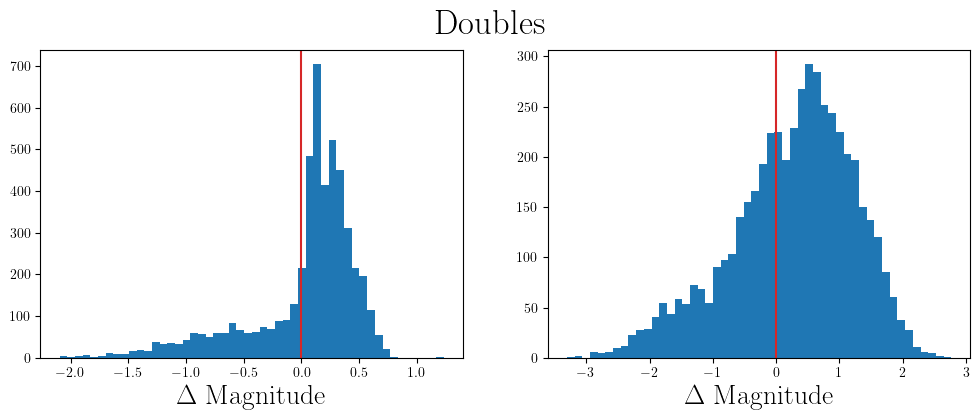

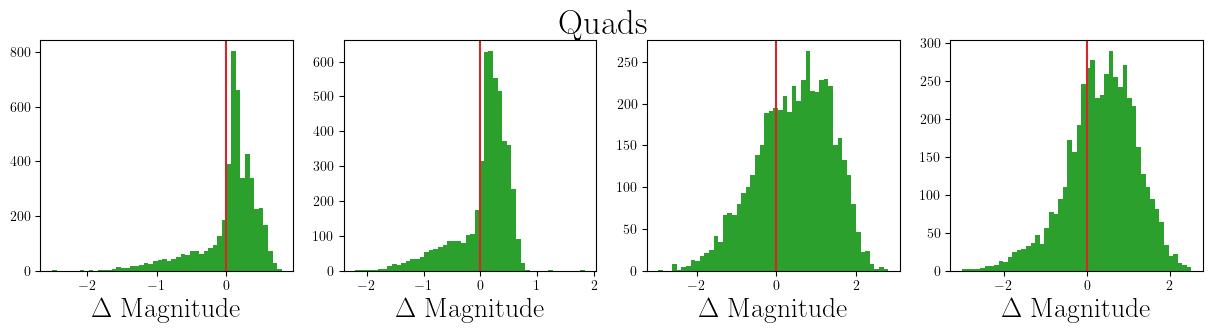

In [35]:
micropeak1, micropeak2 = [], []
mpeak1, mpeak2, mpeak3, mpeak4 = [], [], [], []

for i in range(len(doubles)):
    micropeak1.append(doubles['micro_peak'][i][0])
    micropeak2.append(doubles['micro_peak'][i][1])
    mpeak1.append(quads['micro_peak'][i][0])
    mpeak2.append(quads['micro_peak'][i][1])
    mpeak3.append(quads['micro_peak'][i][2])
    mpeak4.append(quads['micro_peak'][i][3])
    
micropeak1 = np.array(micropeak1)
micropeak2 = np.array(micropeak2)

print("Mean microlensing doubles: ", np.mean(micropeak1), np.mean(micropeak2))
print("Median microlensing doubles: ", np.median(micropeak1), np.median(micropeak2))
print(" ")
print("Mean microlensing quads: ", np.mean(mpeak1), np.mean(mpeak2), np.mean(mpeak3), np.mean(mpeak4))
print("Median microlensing quads: ", np.median(mpeak1), np.median(mpeak2), np.median(mpeak3), np.median(mpeak4))
      
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(micropeak1, bins=50)
ax[0].axvline(x=0, color='C3')
ax[1].axvline(x=0, color='C3')
ax[1].hist(micropeak2, bins=50)
ax[0].set_xlabel(r"$\Delta$ Magnitude", fontsize=20)
ax[1].set_xlabel(r"$\Delta$ Magnitude", fontsize=20)
fig.suptitle("Doubles", fontsize=25)

fig, ax = plt.subplots(1, 4, figsize=(15,3))
ax[0].hist(mpeak1, bins=50, color='C2')
ax[1].hist(mpeak2, bins=50, color='C2')
ax[2].hist(mpeak3, bins=50, color='C2')
ax[3].hist(mpeak4, bins=50, color='C2')
ax[0].axvline(x=0, color='C3')
ax[1].axvline(x=0, color='C3')
ax[2].axvline(x=0, color='C3')
ax[3].axvline(x=0, color='C3')
ax[0].set_xlabel(r"$\Delta$ Magnitude", fontsize=20)
ax[1].set_xlabel(r"$\Delta$ Magnitude", fontsize=20)
ax[2].set_xlabel(r"$\Delta$ Magnitude", fontsize=20)
ax[3].set_xlabel(r"$\Delta$ Magnitude", fontsize=20)
fig.suptitle("Quads", fontsize=25)
plt.show()

435 683 3882


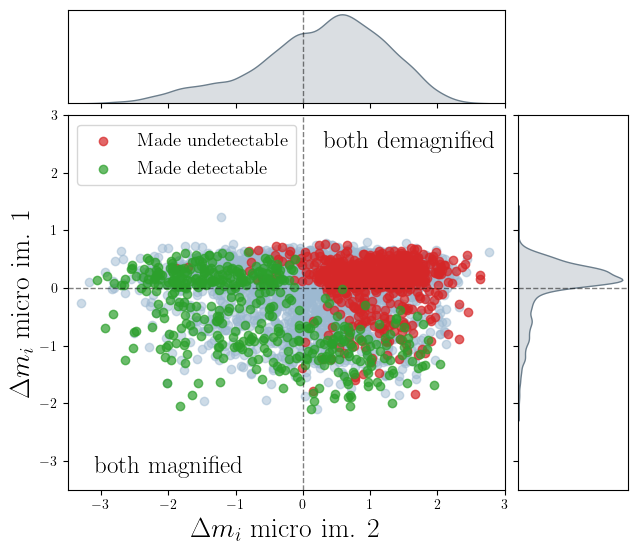

In [38]:
import seaborn as sb

micro_plus = np.where((md_detected_micro) & (md_nondetect))[0]
micro_min = np.where((md_nondetect_micro) & (md_detected))[0]
micro_same = np.where(((md_detected_micro) & (md_detected)) | ((md_nondetect_micro) & (md_nondetect)))
print(len(micropeak1[micro_plus]), len(micropeak1[micro_min]), len(micropeak1[micro_same]))

# Start with a square Figure.
fig = plt.figure(figsize=(7, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

sb.kdeplot(micropeak2, ax=ax_histx, fill=True, color="#6c7e8c", bw_adjust=0.8)
ax_histx.axvline(x=0, color='black', ls='--', lw=1, alpha=0.5)
sb.kdeplot(y=micropeak1, ax=ax_histy, fill=True, color="#6c7e8c", bw_adjust=0.8)
ax_histy.axhline(y=0, color='black', ls='--', lw=1, alpha=0.5)
ax_histx.set_ylabel(" ")
ax_histy.set_xlabel(" ")
ax_histx.tick_params(axis="y", labelbottom=False, left = False, right = False , labelleft = False, bottom = False)
ax_histy.tick_params(axis="x", labelbottom=False, left = False, right = False , labelleft = False, bottom = False)

ax.scatter(micropeak2[micro_same], micropeak1[micro_same], alpha=0.5, color='#9db9d1')
ax.scatter(micropeak2[micro_min], micropeak1[micro_min], color='C3', alpha=0.7, label="Made undetectable")
ax.scatter(micropeak2[micro_plus], micropeak1[micro_plus], color='C2', alpha=0.7, label="Made detectable")
ax.set_xlabel(r"$\Delta m_i$ micro im. 2", fontsize=20)
ax.set_ylabel(r"$\Delta m_i$ micro im. 1", fontsize=20)
ax.axhline(y=0, color='black', ls='--', lw=1, alpha=0.5)
ax.axvline(x=0, color='black', ls='--', lw=1, alpha=0.5)
ax.text(-3.1, -3.2, "both magnified", fontsize=18)
ax.text(0.3, 2.43, "both demagnified", fontsize=18)
ax.set_ylim(-3.5, 3)
ax.set_xlim(-3.5, 3)
ax.legend(loc='upper left', fontsize=13.5)

#plt.savefig("../Results/Figures/Results_0506/Microlensing3_scatterplot_paper.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

Non-rol - mean Nobs:  14.953360768175584  median:  13.0
Rol -     mean Nobs:  16.60007683442182  median:  12.0


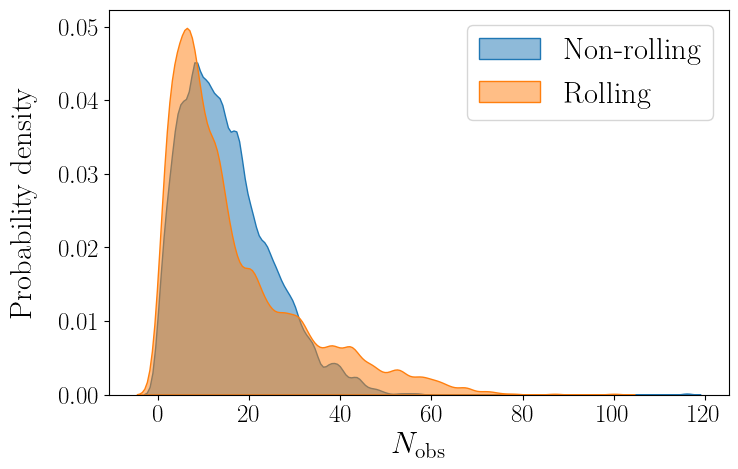

In [24]:
Nobs_nonrol = list(Nobs_doubles[(md_detected_micro) & (md_nonrol)]) + list(Nobs_quads[(mq_detected_micro) & (mq_nonrol)])
Nobs_rol = list(Nobs_doubles[(md_detected_micro) & (md_rol)]) + list(Nobs_quads[(mq_detected_micro) & (mq_rol)])

fig, ax = plt.subplots(1,1, figsize=(8, 5))
seaborn.kdeplot(Nobs_nonrol, ax=ax, fill=True, alpha=0.5, label="Non-rolling", bw_adjust=0.5)
seaborn.kdeplot(Nobs_rol, ax=ax, fill=True, alpha=0.5, label="Rolling", bw_adjust=0.5)
# plt.hist(Nobs_doubles[(md_detected) & (md_nonrol)], bins=40, alpha=0.5, density=True)
# plt.hist(Nobs_doubles[(md_detected) & (md_rol)], bins=40, alpha=0.5, density=True)
ax.set_xlabel(r"$N_{\rm{obs}}$", fontsize=22)
ax.set_ylabel(r"Probability density", fontsize=22, labelpad=15)
plt.legend(fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

print("Non-rol - mean Nobs: ", np.mean(Nobs_nonrol), " median: ", np.median(Nobs_nonrol))
print("Rol -     mean Nobs: ", np.mean(Nobs_rol), " median: ", np.median(Nobs_rol))

#plt.savefig("../Results/Figures/Results_0506/Cadence_Nobs_rolling_nonrolling.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

In [73]:
doubles['snr_unresolved'][10]

array([ 0.        ,  2.02789884,  5.54850602,  3.63550636,  6.09163292,
        4.69342069, 13.18397817,  3.68874892,  0.        ,  6.03021841,
        0.85151143,  0.        ,  0.        ])

In [13]:
def N_glsne(Nobs_lim, cadence, configuration):
    # Calculate the yearly number of detected lensed SNe with N_obs number of observations.
    
    snr_lim = 5
    Nobs_doubles, Nobs_quads = [], []

    for s in range(len(doubles)):
        Nobs_doubles.append(len(doubles['snr_unresolved'][s][doubles['snr_unresolved'][s] > snr_lim]))
        try:
            Nobs_quads.append(len(quads['snr_unresolved'][s][quads['snr_unresolved'][s] > snr_lim]))
        except:
            Nobs_quads.append(np.nan)

    Nobs_doubles = np.array(Nobs_doubles)
    Nobs_quads = np.array(Nobs_quads)
    
    if cadence == 'nonrol' and configuration == 'doubles':
        number = ((md_WFD) & (md_detected_micro) & (md_nonrol) & (Nobs_doubles > Nobs_lim)).sum()*sd2
    elif cadence == 'rol' and configuration == 'doubles':
        number = ((md_WFD) & (md_detected_micro) & (md_rol) & (Nobs_doubles > Nobs_lim)).sum()*sd2
    elif cadence == 'nonrol' and configuration == 'quads':
        number = ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (Nobs_quads > Nobs_lim)).sum()*sq2
    elif cadence == 'rol' and configuration == 'quads':
        number = ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (Nobs_quads > Nobs_lim)).sum()*sq2
    elif cadence == 'nonrol' and configuration == 'all':
        number = ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (Nobs_quads > Nobs_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol) & (Nobs_doubles > Nobs_lim)).sum()*sd2
    elif cadence == 'rol' and configuration == 'all':
        number = ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (Nobs_quads > Nobs_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol) & (Nobs_doubles > Nobs_lim)).sum()*sd2
    
    #elif cadence == 'rol' and configuration == 'all' and rolling == 'active':
    #    number = ((mq_detected) & (mq_rol) & (active_quads) & (Nobs_quads > Nobs_lim)).sum()*sq + ((md_detected) & (md_rol) & (active_doubles) & (Nobs_doubles > Nobs_lim)).sum()*sd 
    
    return number    
    

In [17]:
Nobs_range = np.linspace(1, 100, 100)
N_rol_all = []
N_nonrol_all = []

for n in Nobs_range:
    N_rol_all.append(N_glsne(n, 'rol', 'all'))
    N_nonrol_all.append(N_glsne(n, 'nonrol', 'all'))
    
N_nonrol_all = np.array(N_nonrol_all)
N_rol_all = np.array(N_rol_all)

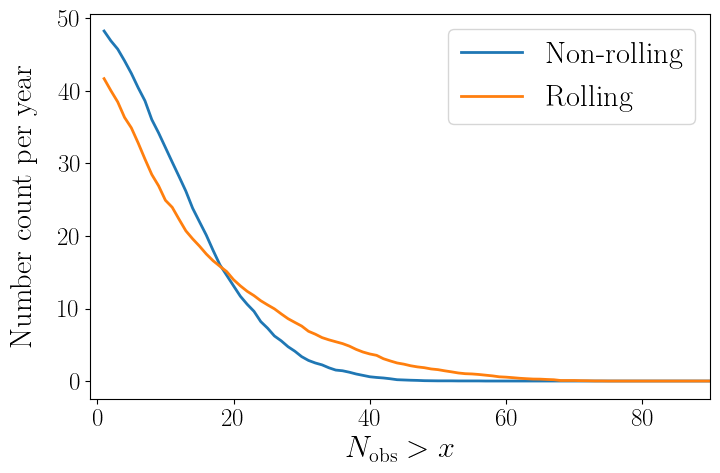

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(Nobs_range, N_nonrol_all, label="Non-rolling", lw=2)
plt.plot(Nobs_range, N_rol_all, label="Rolling", lw=2)

plt.xlabel(r"$N_{\Large \textrm{obs}} > x$", fontsize=22)
plt.ylabel(r"Number count per year", fontsize=22, labelpad=15)
plt.xlim(-1, 90)
plt.legend(fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
#plt.savefig("../Results/Figures/Results_0506//Cadence_Nglsne_Nobs_all.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')



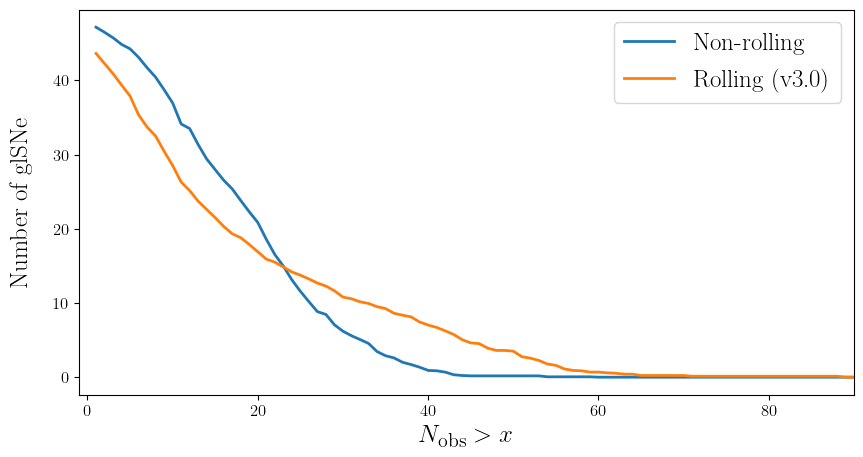

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(Nobs_range, N_nonrol_all, label="Non-rolling", lw=2)
plt.plot(Nobs_range, N_rol_all, label="Rolling (v3.0)", lw=2)

plt.xlabel(r"$N_{\Large \textrm{obs}} > x$", fontsize=18)
plt.ylabel(r"Number of glSNe", fontsize=18, labelpad=15)
plt.xlim(-1, 90)
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
#plt.savefig("../Results/Figures/Cadence_Nglsne_Nobs_all_v30.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

In [55]:
def is_active(coords):
    ra, dec = coords
    return (((dec > -16) & 
            ((ra < 95) | (ra > 260))) | (((dec > -49) & (dec <= -31)) & ((ra <= 120) | (ra > 245))) |
             (((dec > -25) & (dec <= -8)) & (ra >= 110) & (ra <= 245)) | (dec > 3)  | (dec < -72) )

In [57]:
active_

print(doubles['coords'][0])
print(is_active(doubles['coords']))

[354.37869963  -7.23655398]


ValueError: too many values to unpack (expected 2)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(Nobs_range, N_nonrol_all, label="Non-rolling", lw=2)
plt.plot(Nobs_range, N_rol_all, label="Rolling (v3.0)", lw=2)

plt.xlabel(r"$N_{\Large \textrm{obs}} > x$", fontsize=18)
plt.ylabel(r"Number of glSNe", fontsize=18, labelpad=15)
plt.xlim(-1, 90)
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
#plt.savefig("../Results/Figures/Cadence_Nglsne_Nobs_all_v30.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

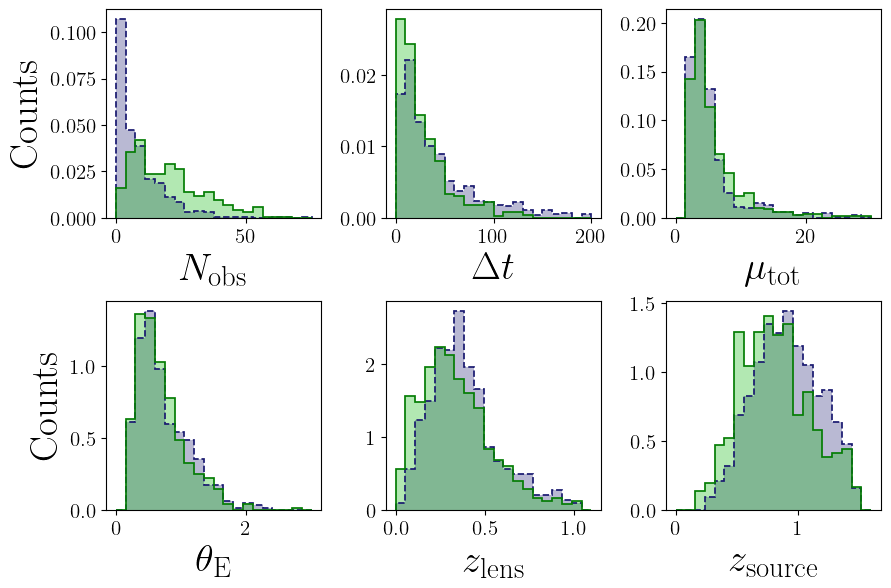

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6.5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
ax = ax.flatten()
bins = 20
fs = 28
tfs = 15

def histogram(data, ax, detected, start=None, stop=None):
    
    kwargs1 = {'density': True, 'bins': bins, 'histtype': 'stepfilled', 'alpha': 0.3}
    kwargs2 = {'density': True, 'bins': bins, 'histtype': 'step', 'lw': 1.25}
    
    if detected:
        color1 = '#00b300'
        color2 = '#057d05'
        ls = '-'
    else:
        color = '#9731e0'
        color1 = 'midnightblue'
        color2 = 'midnightblue'
        ls = '--'
              
    if start == None:
        start = min(data)
    if stop == None:
        stop = max(data)
              
    ax.hist(data, color=color1, range=(start, stop), **kwargs1)
    ax.hist(data, color=color2, range=(start, stop), ls=ls, **kwargs2)


for a in ax:
    a.tick_params(axis='both', which='major', labelsize=tfs)
    a.tick_params(axis='both', which='minor', labelsize=tfs)
    
histogram(Nobs_doubles[md_nondetect], ax[0], detected=False, start=0, stop=75)
histogram(Nobs_doubles[md_detected], ax[0], detected=True, start=0, stop=75)
ax[0].set_ylabel("Counts", fontsize=fs)
ax[0].set_xlabel(r"$N_{\huge \textrm{obs}}$", fontsize=fs)

histogram(dt_doubles[md_nondetect], ax[1], detected=False, start=0, stop=200)
histogram(dt_doubles[md_detected], ax[1], detected=True, start=0, stop=200)
ax[1].set_xlabel(r"$\Delta{t}$", fontsize=fs)

histogram(mutot_doubles[md_nondetect], ax[2], detected=False, start=0, stop=30)
histogram(mutot_doubles[md_detected], ax[2], detected=True, start=0, stop=30)
ax[2].set_xlabel(r"$\mu_{\huge \textrm{tot}}$", fontsize=fs)

histogram(doubles['theta_E'][md_nondetect], ax[3], detected=False, start=0, stop=3)
histogram(doubles['theta_E'][md_detected], ax[3], detected=True, start=0, stop=3)
ax[3].set_xlabel(r"$\theta_{\huge \textrm{E}}$", fontsize=fs)
ax[3].set_ylabel("Counts", fontsize=fs)

histogram(doubles['z_lens'][md_nondetect], ax[4], detected=False, start=0, stop=1.1)
histogram(doubles['z_lens'][md_detected], ax[4], detected=True, start=0, stop=1.1)
ax[4].set_xlabel(r"$z_{\huge \textrm{lens}}$", fontsize=fs)

histogram(doubles['z_source'][md_nondetect], ax[5], detected=False, start=0, stop=1.6)
histogram(doubles['z_source'][md_detected], ax[5], detected=True, start=0, stop=1.6)
ax[5].set_xlabel(r"$z_{\huge \textrm{source}}$", fontsize=fs)

# plt.savefig("../Results/Figures/Cadence_accepted_rejected_doubles.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

In [286]:
index_base_gold = doubles[(md_WFD) & (md_detected_micro)].index
index_base_gold = index_base_gold[index_base_gold < 1000]

In [289]:
doubles.iloc[210]

time_series                                                                 NaN
z_source                                                               1.076813
z_lens                                                                 0.628011
H0                                                                         67.8
theta_E                                                                 0.45655
obs_peak                      [[nan, nan], [inf, inf], [22.102455507414525, ...
obs_times                     [-41.53625454955909, -41.51149335067021, -34.5...
obs_bands                     [z, y, g, r, g, r, i, z, y, y, y, g, g, i, z, ...
model_mag                     [[inf, inf], [28.702217374018417, inf], [nan, ...
obs_mag                       [[inf, inf], [inf, inf], [nan, nan], [inf, inf...
obs_mag_error                 [[nan, nan], [nan, nan], [nan, nan], [nan, nan...
obs_snr                       [[0.0, 0.0], [0.0, 0.0], [nan, nan], [0.0, 0.0...
obs_mag_unresolved            [nan, nan,

In [288]:
list(index_base_gold)

[1,
 6,
 9,
 10,
 11,
 16,
 18,
 24,
 29,
 33,
 34,
 36,
 38,
 42,
 45,
 51,
 52,
 54,
 55,
 57,
 58,
 62,
 63,
 67,
 69,
 70,
 71,
 72,
 74,
 81,
 84,
 85,
 93,
 94,
 108,
 110,
 114,
 119,
 120,
 121,
 124,
 125,
 128,
 129,
 136,
 137,
 143,
 146,
 155,
 160,
 162,
 164,
 167,
 170,
 171,
 172,
 173,
 177,
 181,
 184,
 186,
 188,
 189,
 190,
 191,
 197,
 201,
 203,
 206,
 207,
 210,
 215,
 221,
 225,
 226,
 228,
 230,
 233,
 238,
 240,
 246,
 253,
 257,
 258,
 262,
 270,
 273,
 275,
 277,
 278,
 281,
 282,
 283,
 286,
 297,
 298,
 300,
 302,
 305,
 307,
 308,
 310,
 312,
 313,
 314,
 321,
 323,
 328,
 330,
 335,
 336,
 338,
 345,
 347,
 349,
 350,
 352,
 358,
 360,
 363,
 365,
 366,
 367,
 368,
 370,
 372,
 374,
 378,
 390,
 394,
 395,
 399,
 400,
 403,
 405,
 409,
 412,
 413,
 414,
 415,
 418,
 420,
 426,
 428,
 429,
 436,
 438,
 442,
 446,
 448,
 455,
 457,
 461,
 462,
 466,
 468,
 472,
 479,
 483,
 485,
 489,
 501,
 507,
 509,
 510,
 511,
 512,
 514,
 517,
 522,
 523,
 524,
 527,

In [51]:
# print(doubles[np.around(doubles['z_source'], 3) == 0.464])

print(doubles.iloc[636])

time_series                                                                 NaN
z_source                                                               0.464989
z_lens                                                                 0.142165
H0                                                                         67.8
theta_E                                                                 0.63424
obs_peak                      [[23.33848619182288, 25.181521872767732], [21....
obs_times                     [-28.878501829665765, -28.854171193110233, -27...
obs_bands                     [r, i, g, r, r, i, y, i, z, i, z, z, y, y, g, ...
model_mag                     [[31.069814830755806, inf], [31.47682694142904...
obs_mag                       [[inf, inf], [inf, inf], [inf, inf], [inf, inf...
obs_mag_error                 [[nan, nan], [nan, nan], [nan, nan], [nan, nan...
obs_snr                       [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...
obs_mag_unresolved            [nan, nan,